# Import the required libraries

In [90]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix,accuracy_score,classification_report,mean_squared_error
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold
from sklearn.feature_selection import RFE,RFECV
from sklearn.preprocessing import LabelEncoder
from imblearn.over_sampling import SMOTE,ADASYN
from sklearn import preprocessing
from sklearn import metrics
from sklearn.tree import DecisionTreeClassifier,plot_tree
import sklearn.tree as tree
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold

# Load Data From CSV File

In [91]:
df=pd.read_csv("credit_risk.csv")

In [92]:
df.head()

,Id,Age,Income,Home,Emp_length,Intent,Amount,Rate,Status,Percent_income,Default,Cred_length
0,0,22,59000,RENT,123.0,PERSONAL,35000,16.02,1,0.59,Y,3
1,1,21,9600,OWN,5.0,EDUCATION,1000,11.14,0,0.10,N,2
2,2,25,9600,MORTGAGE,1.0,MEDICAL,5500,12.87,1,0.57,N,3
3,3,23,65500,RENT,4.0,MEDICAL,35000,15.23,1,0.53,N,2
4,4,24,54400,RENT,8.0,MEDICAL,35000,14.27,1,0.55,Y,4



### Sütun Analizi
1. **Id**: Kişinin benzersiz kimlik numarası.
2. **Age**: Kişinin yaşı.
3. **Income**: Yıllık geliri (muhtemelen USD cinsinden).
4. **Home**: Kişinin konut durumu. Örneğin, "RENT" (kiracı), "OWN" (ev sahibi) veya "MORTGAGE" (ipotekli ev).
5. **Emp_length**: İşteki kıdem süresi (yıllar olarak).
6. **Intent**: Kredi talebinin amacı. Örneğin, "PERSONAL" (kişisel harcama), "EDUCATION" (eğitim), "MEDICAL" (sağlık harcamaları).
7. **Amount**: Talep edilen kredi tutarı.
8. **Rate**: Kredinin faiz oranı (%).
9. **Status**: Kredinin durumu. 1: Kabul edilmiş, 0: Reddedilmiş.
10. **Percent_income**: Talep edilen kredi tutarının, yıllık gelire oranı.
11. **Default**: Ödeme temerrüdü durumu. "Y" (evet), "N" (hayır).
12. **Cred_length**: Kredi geçmişi süresi (yıllar olarak).

---

### Yorumlama
#### Genel Görünüm:
- Yaşlar genellikle genç bireyleri (21-25 yaş arası) kapsıyor.
- Ev sahipliği durumu çoğunlukla "RENT" (kiralık) görünüyor.
- İş kıdem süresi (Emp_length) oldukça farklılık gösteriyor, bazıları yeni işe başlamışken (1 yıl), bazıları oldukça kıdemli (8 yıl).

#### Kredi Talebi:
- **Yüksek kredi tutarları** (örneğin, 35000) faiz oranlarının (Rate) da genelde daha yüksek olduğunu gösteriyor. Bu, riskin kredi tutarıyla artabileceğini düşündürebilir.
- **Percent_income**: Gelire oranla yüksek kredi talebi (örneğin, %59 ve %57), temerrüt durumlarının (Default) daha olası olduğu gözlemlenebilir.

#### Temerrüt ve Kabul Durumu:
- **Default (Temerrüt):** Örneklerde "Y" işaretli kişilerin (satır 0 ve 4) krediyi geri ödeyemediği görülüyor. Bu kişiler, yüksek faiz oranı ve/veya gelire kıyasla yüksek kredi talebi olan bireylerdir.
- **Status (Kabul Edilme):** Kredilerin çoğu onaylanmış (Status = 1). Ancak, faiz oranı düşük olan (11.14%) satırda bir kredi reddi var. Bu kişi, talep edilen tutar ve gelir oranı oldukça düşük (10%).

#### İlginç Noktalar:
1. **Satır 0:** Yıllık gelire göre (%59) çok yüksek kredi talebinde bulunmuş ve temerrüde düşmüş. 
2. **Satır 1:** Düşük gelir ve düşük kredi talebine rağmen, kredi reddedilmiş (Status = 0).
3. **Satır 4:** Yüksek kıdem (8 yıl) ve nispeten makul bir gelirle (54400) kredi kabul ın optimize edilmesine yardımcı olabilir. 😊

In [93]:
# Veriyi yeniden sıralama: 'data' adında yeni bir DataFrame oluşturuluyor
# Sütunların sırasını belirttiğimiz şekilde yeniden düzenliyoruz.
data = df.reindex(columns=["Id", "Age", "Income", "Home", "Emp_length", 
                           "Intent", "Amount", "Rate", "Percent_income", 
                           "Default", "Cred_length", "Status"])

# İlk 110 satırı görüntüleme: 'data' DataFrame'inin ilk 110 satırını görselleştiriyoruz.
data.head(110)

,Id,Age,Income,Home,Emp_length,Intent,Amount,Rate,Percent_income,Default,Cred_length,Status
0,0,22,59000,RENT,123.0,PERSONAL,35000,16.02,0.59,Y,3,1
1,1,21,9600,OWN,5.0,EDUCATION,1000,11.14,0.10,N,2,0
2,2,25,9600,MORTGAGE,1.0,MEDICAL,5500,12.87,0.57,N,3,1
3,3,23,65500,RENT,4.0,MEDICAL,35000,15.23,0.53,N,2,1
4,4,24,54400,RENT,8.0,MEDICAL,35000,14.27,0.55,Y,4,1
...,...,...,...,...,...,...,...,...,...,...,...,...
105,105,22,12600,MORTGAGE,NaN,PERSONAL,2000,5.42,0.16,N,4,1
106,106,25,12600,OWN,3.0,PERSONAL,1750,13.61,0.14,N,3,0
107,107,21,42500,RENT,3.0,EDUCATION,25000,12.73,0.59,Y,3,1
108,108,24,41000,RENT,2.0,HOMEIMPROVEMENT,25000,NaN,0.61,N,3,1


# Data Visualization and Analysis

#  Data Visualization

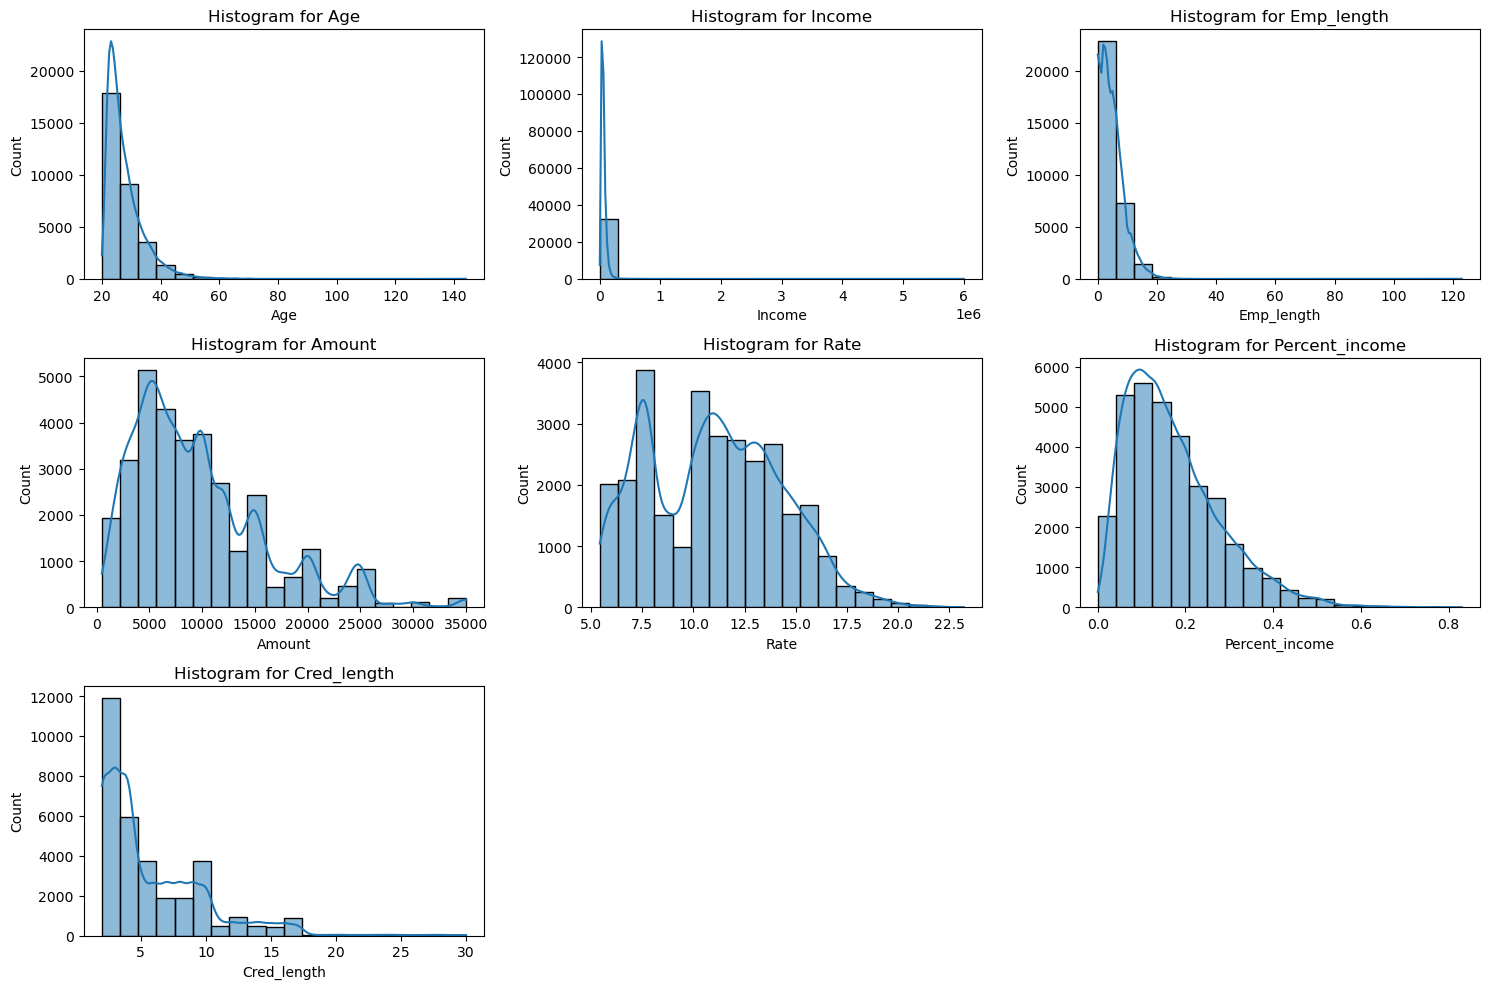

In [94]:
# Sayısal sütunların bir listesi tanımlanıyor.
numerical_features = ['Age', 'Income', 'Emp_length', 'Amount', 'Rate', 
                      'Percent_income', 'Cred_length']

# Grafik boyutunu ayarlıyoruz: Genel figür alanı 15x10 boyutunda.
plt.figure(figsize=(15, 10))

# Döngü: Her bir sayısal özelliğin histogramını oluşturuyoruz.
for i, feature in enumerate(numerical_features, 1):  # enumerate ile özelliğin sırası ve adı alınıyor.
    plt.subplot(3, 3, i)  # Histogramı 3x3 ızgarada bir alt grafik (subplot) olarak yerleştiriyoruz.
    sns.histplot(data[feature], bins=20, kde=True)  # Histogram: 20 bin ve KDE (yoğunluk eğrisi) ile çiziliyor.
    plt.title(f'Histogram for {feature}')  # Grafik başlığını özelliğin adıyla oluşturuyoruz.

# Alt grafikler arasındaki boşluğu düzgün hale getiriyoruz.
plt.tight_layout()

# Histogramları görüntülüyoruz.
plt.show()

### **Histogram Analizi**
Histogramlar, sütunların dağılımını gösterir ve veri kümesinin şekli hakkında fikir verir.

- **Age:**
  - Dağılım sağa çarpık (pozitif çarpıklık). 
  - Genç yaş grupları (20-30 yaş) ağırlıkta, yaş arttıkça sayılar hızla azalıyor.

- **Income:**
  - Gelir oldukça sağa çarpık. 
  - Çoğu kişi düşük gelir grubunda (10,000-50,000). Çok yüksek gelirler nadir.

- **Emp_length:**
  - Çalışma süresi genelde düşük değerlerde yoğunlaşıyor (0-10 yıl). 
  - Uzun çalışma süresi olanlar (20 yıl ve üzeri) çok az.

- **Amount:**
  - Kredi tutarı, genelde 0-10,000 aralığında yoğunlaşmış. 
  - Daha büyük kredi miktarları daha az görülüyor.

- **Rate:**
  - Faiz oranı neredeyse simetrik bir dağılıma sahip (7.5-12.5 arasında yoğunlaşmış). 
  - Aşırı yüksek faiz oranları nadir.

- **Percent_income:**
  - Gelirin krediye ayrılan yüzdesi çoğunlukla düşük (%0.1-%0.3 aralığında). 
  - Yüksek değerler daha nadir.

- **Cred_length:**
  - Kredi geçmişi 5-10 yıl arasında yoğunlaşmış, sağa çarpık bir dağılıma sahip. 
  - 20 yılın üzerindeki geçmişler çok az.

---



### **Histogram Genel Yorumu**  
Histogramlar, veri sütunlarının dağılımını anlamak için önemli bilgiler sunmaktadır. **Age**, **Income** ve **Amount** gibi sütunlarda dağılımın sağa çarpık olduğu görülmektedir; bu, düşük değerlere sahip veri noktalarının daha yaygın olduğunu, yüksek değerlerin ise nadir olduğunu göstermektedir. Bununla birlikte, **Rate** gibi özellikler daha dengeli bir dağılıma sahip, bu da faiz oranlarının belirli bir aralıkta standartlaştığını göstermektedir. Çoğu veri sütunu, düşük ve orta seviyelerde yoğunlaşmış olup, uç değerlerin genel analize etkisi sınırlı tutulmalıdır. Bu sonuçlar, dağılımlar üzerinde gerekli dönüşümleri (log veya Box-Cox gibi) uygulama ihtiyacını işaret edebilir.

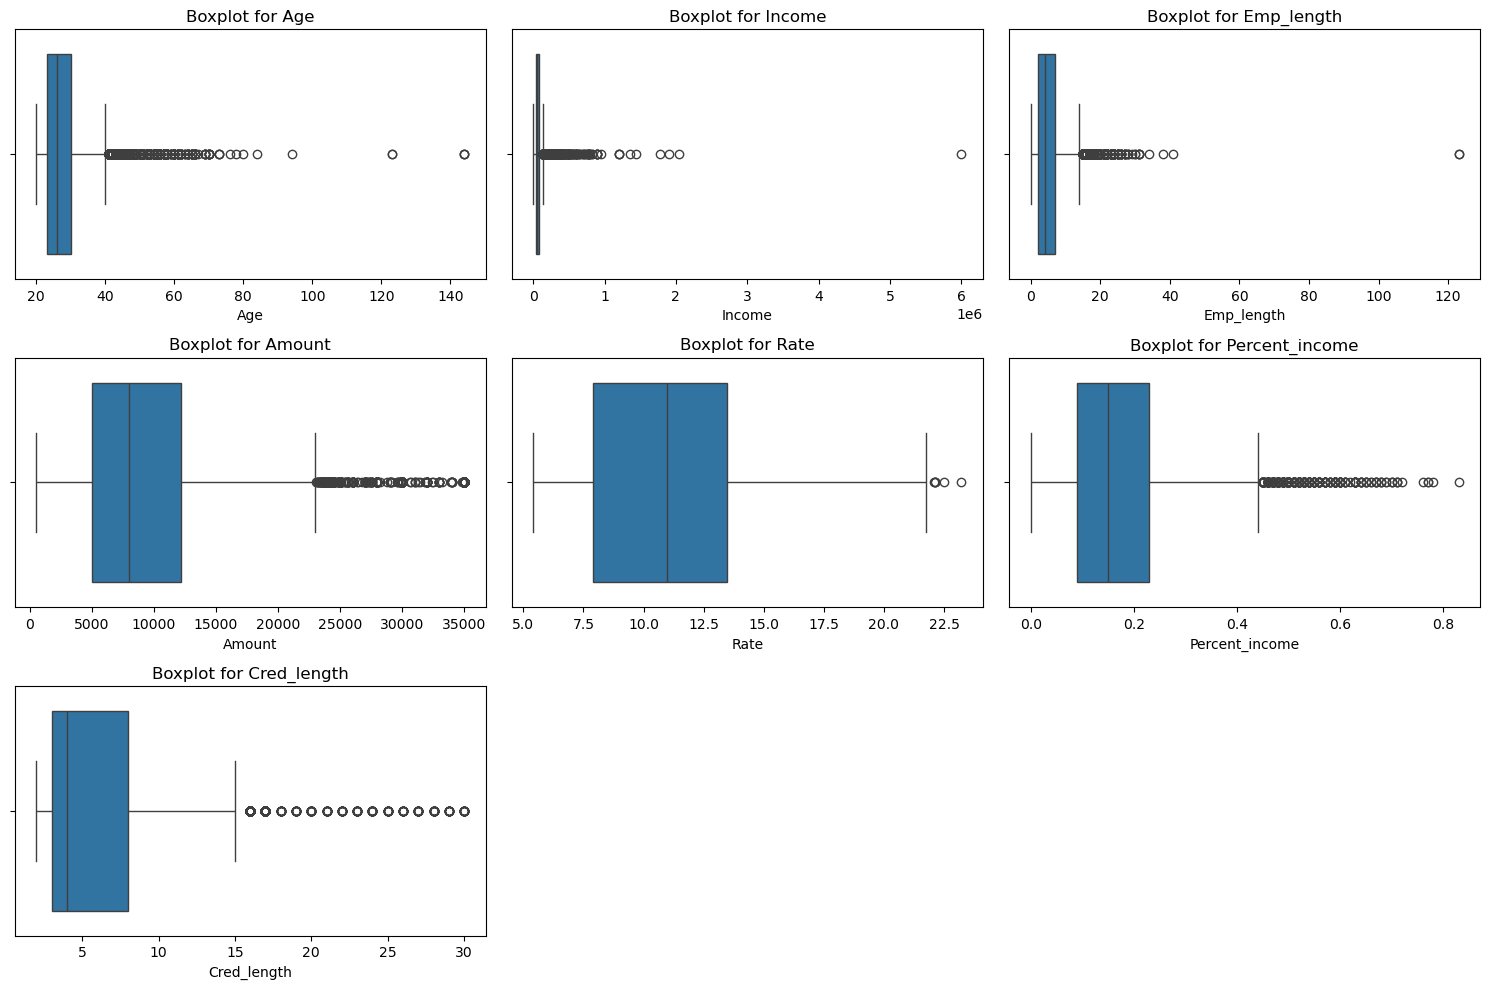

In [95]:
# Grafik alanını oluşturuyoruz ve boyutunu belirliyoruz.
# Genel figür alanı 15x10 boyutunda olacak.
plt.figure(figsize=(15, 10))

# Döngü: Her bir sayısal özelliğin kutu grafiğini oluşturuyoruz.
for i, feature in enumerate(numerical_features, 1):  # enumerate ile özelliğin sırası ve adı alınıyor.
    plt.subplot(3, 3, i)  # Kutu grafiğini 3x3 ızgarada bir alt grafik (subplot) olarak yerleştiriyoruz.
    sns.boxplot(x=data[feature])  # Seaborn ile belirli sütunun kutu grafiğini çiziyoruz.
    plt.title(f'Boxplot for {feature}')  # Grafik başlığını özelliğin adıyla oluşturuyoruz.

# Alt grafikler arasındaki boşluğu düzgün hale getiriyoruz.
plt.tight_layout()

# Grafiklerin ekranda gösterilmesi.
plt.show()

### **Boxplot Analizi**
Kutu grafikleri, merkezi eğilimler, veri dağılımı ve aykırı değerlerin tespiti için kullanılır.

- **Age (Yaş):** 
  - Çoğu değer 20-40 yaş arasında yoğunlaşmış. 
  - 80 yaşın üzerindeki değerler aykırı olarak görünüyor.
  - Veride gerçekçi olmayan yüksek yaşlar (örn. 140 yaş) mevcut.

- **Income (Gelir):** 
  - Gelir büyük ölçüde 0 ile 100,000 arasında yoğunlaşmış. 
  - 1 milyon ve üzeri gelirler aykırı değer olarak dikkat çekiyor.

- **Emp_length (Çalışma Süresi):**
  - Çalışma süresi genellikle 0-20 yıl arasında yoğunlaşmış. 
  - 50 yılın üzerindeki değerler aykırı olabilir.

- **Amount (Kredi Miktarı):**
  - Çoğu kredi tutarı 0-15,000 aralığında. 
  - 25,000 üzerindeki kredi tutarları aykırı değer olarak görünüyor.

- **Rate (Faiz Oranı):**
  - Faiz oranları genelde 7.5-12.5 aralığında yoğunlaşmış. 
  - 20 üzeri faiz oranları oldukça nadir.

- **Percent_income (Gelirin Yüzdesi):**
  - Çoğu kişi gelirin %0.1-0.3 aralığında kredi ödemesi yapıyor. 
  - %0.5 üzerindeki değerler nadir ve aykırı olabilir.

- **Cred_length (Kredi Geçmişi Uzunluğu):**
  - Kredi geçmişi genelde 5-15 yıl aralığında yoğunlaşmış. 
  - 25 yılın üzerindeki değerler aykırı görünüyor.

---

### **Boxplot Genel Yorumu**  
Boxplot’lar, veri kümesindeki aykırı değerlerin varlığını net bir şekilde ortaya koymaktadır. Özellikle **Income (Gelir)**, **Age (Yaş)** ve **Emp_length (Çalışma Süresi)** sütunlarında birçok aykırı değer bulunmaktadır. Örneğin, 1 milyonun üzerindeki gelirler, 80 yaşın üzerindeki yaşlar ve 50 yılın üzerindeki çalışma süreleri aykırı olarak değerlendirilebilir. Bu durum, analiz sürecinde bu değerlerin dikkatle incelenmesi ve gerekirse ayıklanması gerektiğini göstermektedir. Ayrıca, çoğu özellik için veri dağılımı büyük ölçüde düşük değerler çevresinde yoğunlaşmış olup, medyan değerlerin genellikle ortalamadan daha düşük olduğunu göstermektedir.  

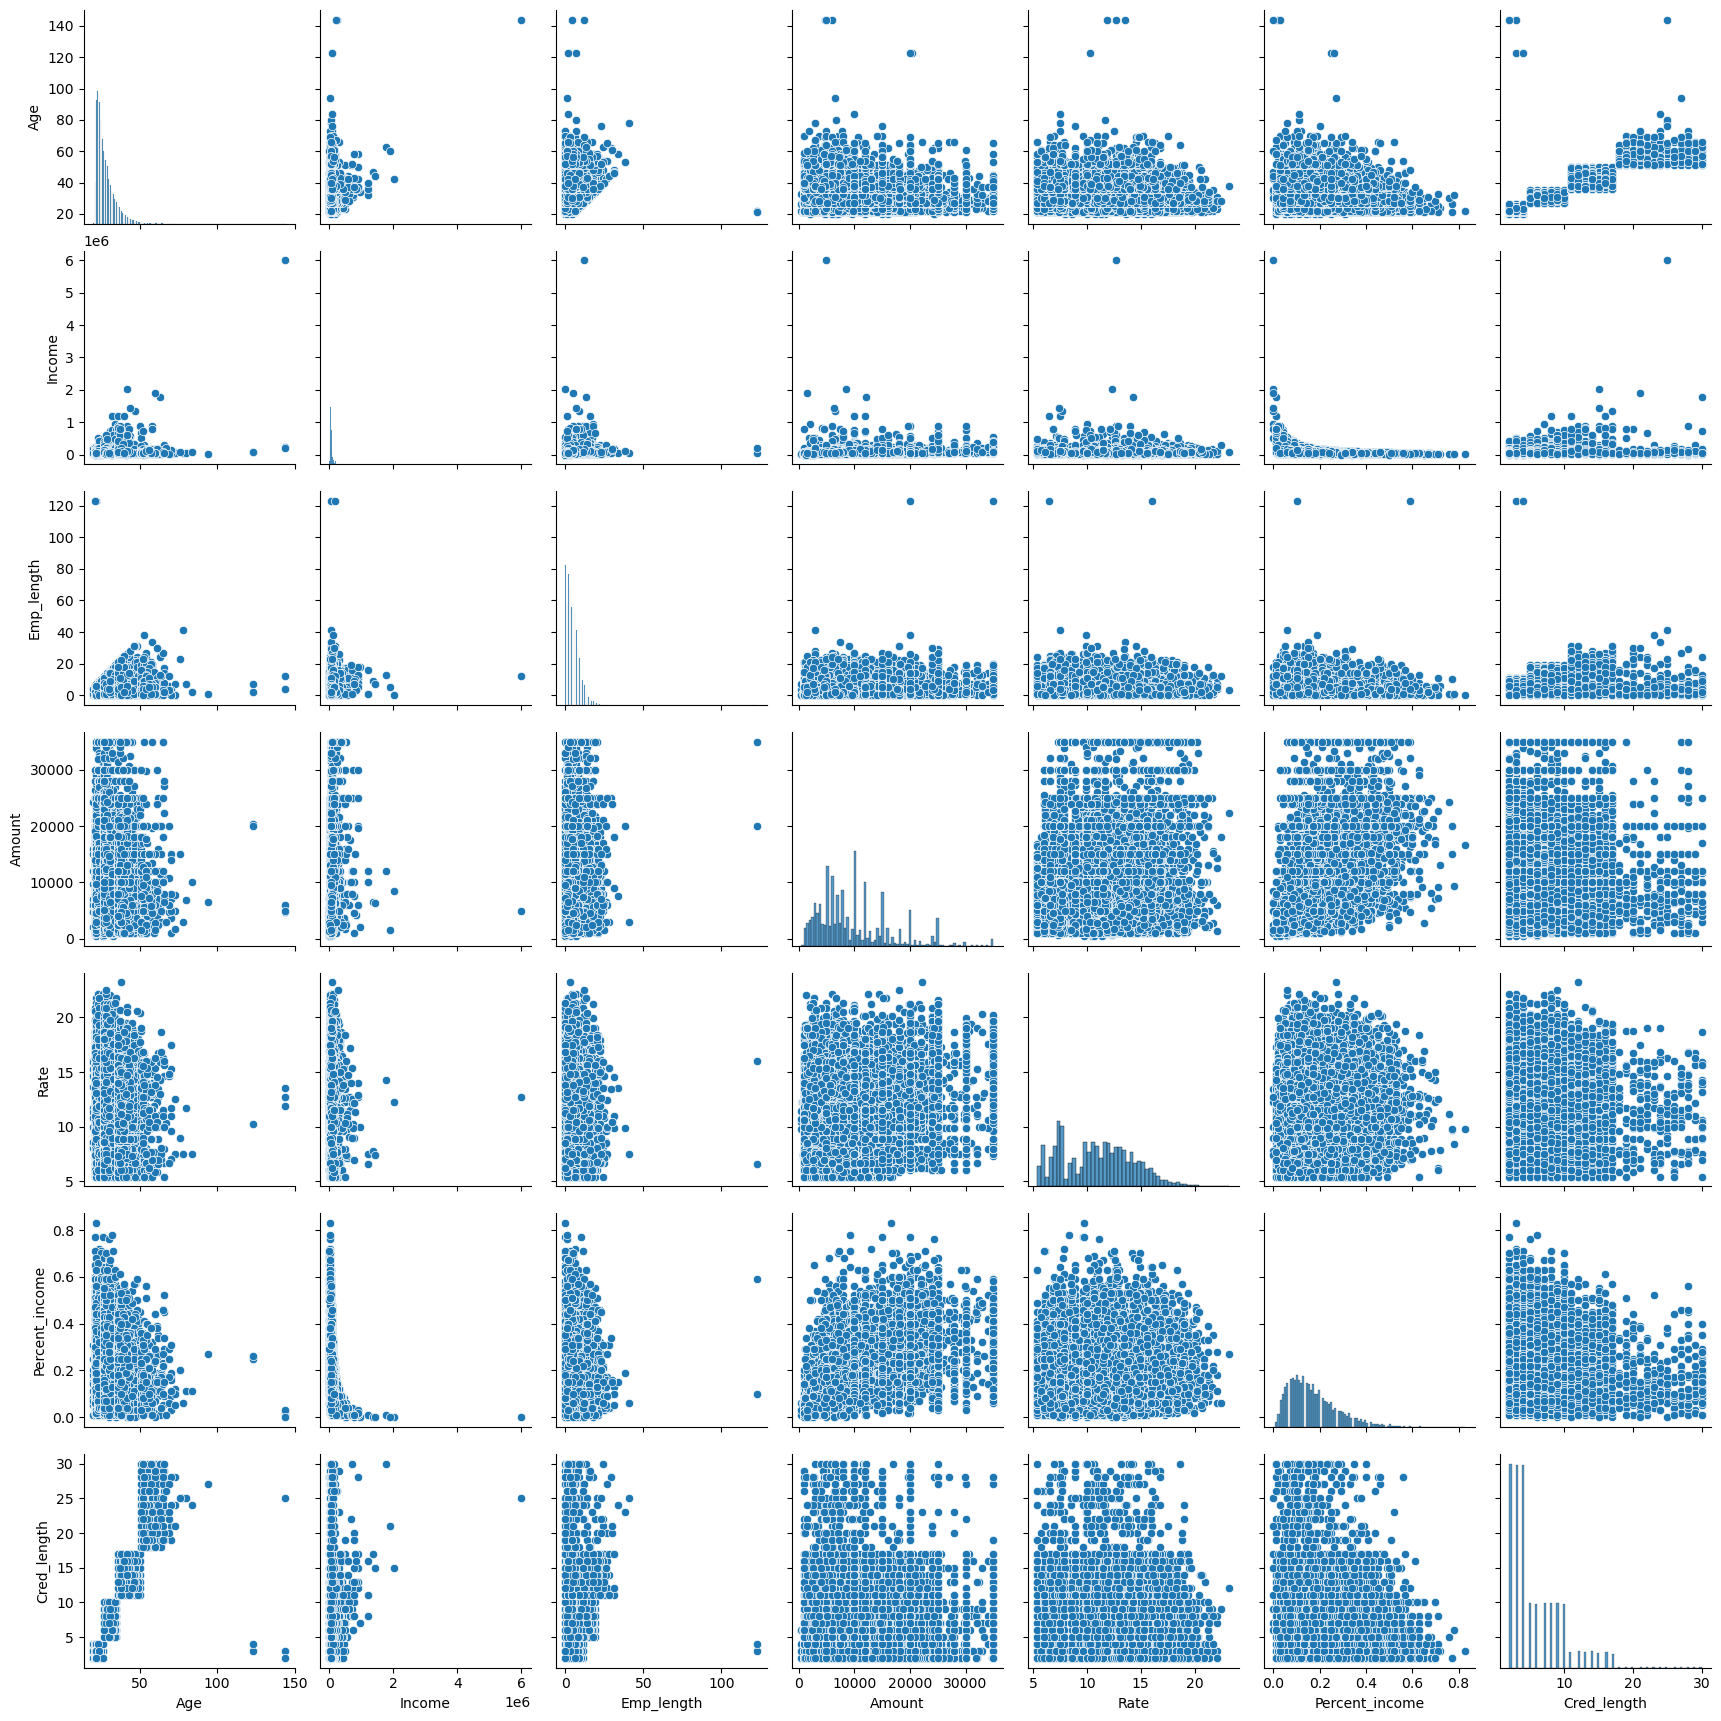

In [96]:
# Pairplot for numerical features
sns.pairplot(data[numerical_features])
plt.show()

### **Pairplot Yorumları**
Pairplot, veri setindeki sayısal değişkenler arasındaki ilişkileri çiftler halinde görselleştirir. Yorumlar:

1. **Dağılımlar**:
   - Özellikle `Age`, `Income`, `Emp_length`, ve `Cred_length` gibi değişkenler sağa çarpık bir dağılıma sahiptir. Bu, verinin büyük bir kısmının düşük değerlere yoğunlaştığını ve az sayıda yüksek değerli gözlem bulunduğunu gösterir.
   - `Amount` ve `Percent_income` ise daha geniş bir aralıkta dağılmış gibi görünüyor.

2. **İlişkiler**:
   - `Age` ile `Cred_length` arasında pozitif bir ilişki gözlemleniyor. Bu, yaş arttıkça kredi geçmişinin de genelde arttığını (uzun olduğunu) gösterir.
   - `Income` ve diğer değişkenler arasında belirgin bir korelasyon gözlemlenmemiştir.
   - Çapraz grafiklerde belirli bir doğrusal ilişki dışında yoğunluk alanları belirgin, yani değişkenlerin çoğu belirli bölgelerde toplanmış.

---

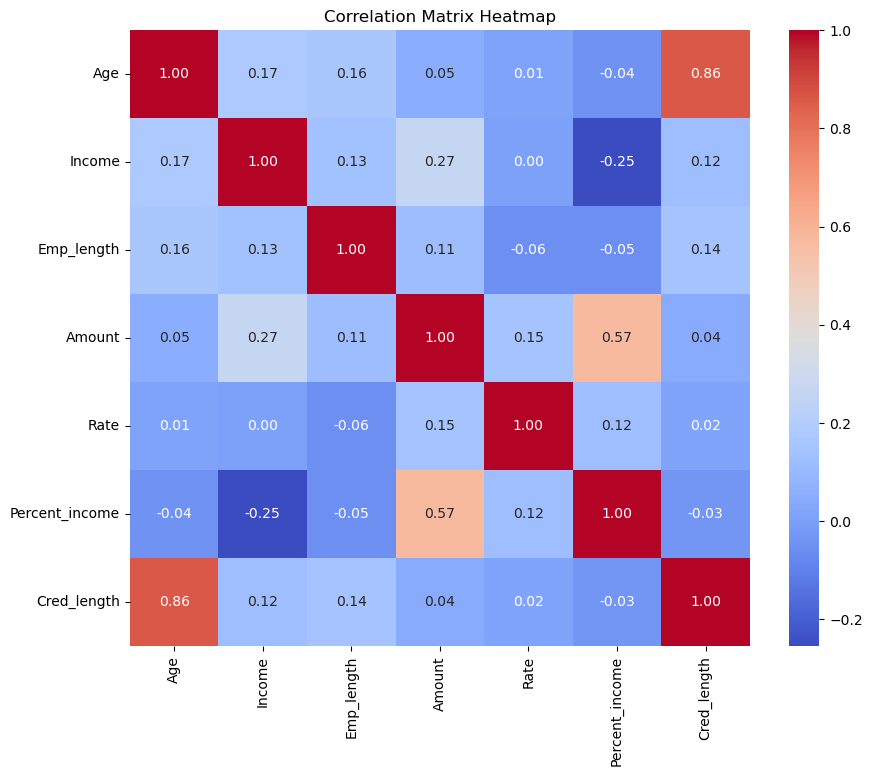

In [97]:
# Korelasyon matrisi hesaplanıyor.
# Sayısal sütunlardan oluşan 'numerical_features' veri çerçevesi kullanılarak korelasyon katsayıları bulunuyor.
correlation_matrix = data[numerical_features].corr()

# Grafik alanı oluşturuluyor ve boyutu ayarlanıyor (10x8 inç).
plt.figure(figsize=(10, 8))

# Isı haritası (heatmap) oluşturuluyor:
# - Korelasyon matrisini 'sns.heatmap()' ile görselleştiriyoruz.
# - 'annot=True' ile her hücreye korelasyon katsayıları ekleniyor.
# - 'cmap="coolwarm"' renk haritasını belirliyor: Mavi ve kırmızı tonları korelasyonu gösterir.
# - 'fmt=".2f"' hücrelerdeki sayıları iki ondalık basamakla formatlar.
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")

# Başlık ekleniyor.
plt.title('Correlation Matrix Heatmap')

# Grafiklerin ekranda görüntülenmesi.
plt.show()

### **Korelasyon Matrisi Yorumları**
Korelasyon matrisindeki değerler, değişkenler arasındaki doğrusal ilişkilerin gücünü gösterir. Yorumlar:

1. **Güçlü Pozitif Korelasyonlar**:
   - `Age` ile `Cred_length` arasında yüksek (0.86) bir pozitif korelasyon var. Yaşlandıkça kredi geçmişinin daha uzun olması, mantıklı bir sonuçtur.
   - `Amount` ile `Percent_income` arasında 0.57’lik pozitif bir korelasyon var. Yüksek kredi miktarı talep eden bireylerin gelir oranlarının da yüksek olduğu görülüyor.

2. **Zayıf veya Negatif Korelasyonlar**:
   - `Income` ile diğer değişkenler arasında genel olarak zayıf bir korelasyon mevcut. Bu, gelirin diğer değişkenlerle direkt bir ilişki kurmadığını gösteriyor.
   - `Rate` (faiz oranı) değişkeni diğer değişkenlerle düşük korelasyon göstermiş. Bu da faiz oranının bireysel özelliklerden çok dış faktörlere bağlı olabileceğini işaret ediyor.

3. **Dikkat Çeken Korelasyon Eksiklikleri**:
   - `Income` ve `Rate` arasında korelasyon neredeyse sıfır (0.00). Gelir seviyesinin faiz oranı ile etkilenmediğini gösterir.
   - `Emp_length` (çalışma süresi) diğer değişkenlerle güçlü bir ilişki göstermiyor.

---

Bu grafikleri birlikte değerlendirdiğimizde, veri setinin belirli değişkenler arasında beklenen ilişkileri gösterdiğini (örneğin `Age` ve `Cred_length`), ancak diğerlerinde düşük veya anlamlı bir ilişki bulunmadığını söyleyebiliriz. Veri analizi için modelleme yapılırken bu zayıf ilişkiler dikkate alınabilir.

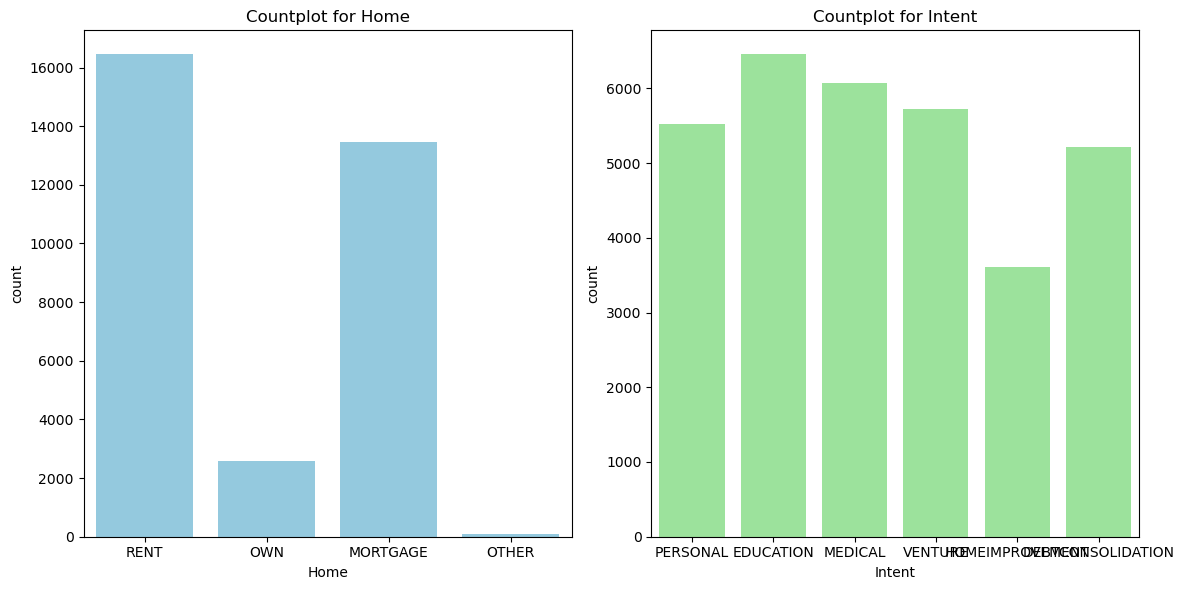

In [98]:
# Grafik boyutunu ayarla
plt.figure(figsize=(12, 6))

# Birinci Countplot: Home değişkeni için değerlerin dağılımı
plt.subplot(1, 2, 1)  # 1 satır, 2 sütun, 1. grafik
sns.countplot(x=categorical_feature_1, data=data, color='skyblue')  # Sütun grafiği, renk olarak skyblue
plt.title(f'Countplot for {categorical_feature_1}')  # Grafiğe başlık ekle

# İkinci Countplot: Intent değişkeni için değerlerin dağılımı
plt.subplot(1, 2, 2)  # 1 satır, 2 sütun, 2. grafik
sns.countplot(x=categorical_feature_2, data=data, color='lightgreen')  # Sütun grafiği, renk olarak lightgreen
plt.title(f'Countplot for {categorical_feature_2}')  # Grafiğe başlık ekle

# İki grafiğin düzenlenmesini sağla
plt.tight_layout()  # Grafiklerin üst üste binmemesi için düzenleme
plt.show()  # Grafikleri ekranda göster

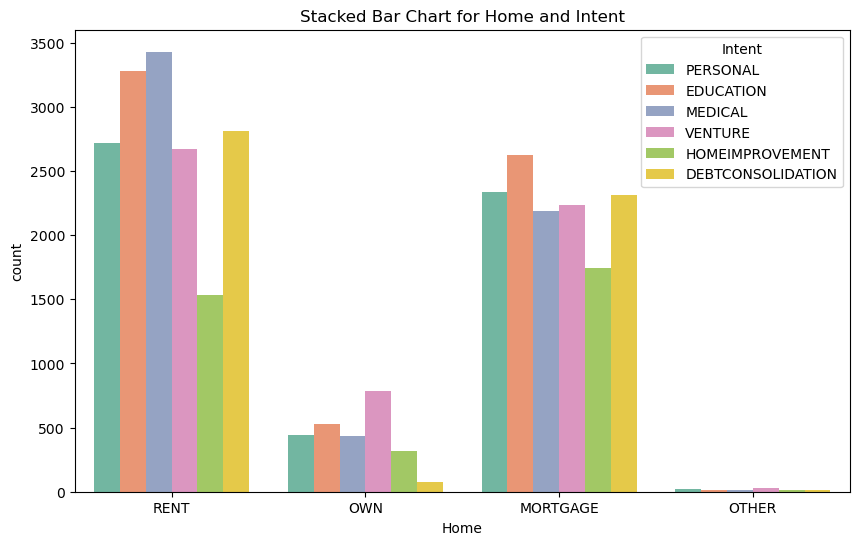

In [99]:
# Grafik boyutunu ayarla
plt.figure(figsize=(10, 6))

# Stacked Bar Chart: Home ve Intent değişkenlerinin ilişkisi
sns.countplot(x=categorical_feature_1, hue=categorical_feature_2, data=data, palette='Set2')  
# Home değişkenine göre kategoriler oluşturulur, Intent değişkeni ile gruplama yapılır.
plt.title(f'Stacked Bar Chart for {categorical_feature_1} and {categorical_feature_2}')  # Grafiğe başlık ekle

# Grafiği ekranda göster
plt.show()

# Data Analysis 

In [100]:
data[["Status"]].value_counts()

Status
0         25473
1          7108
Name: count, dtype: int64

In [101]:
data.columns

Index(['Id', 'Age', 'Income', 'Home', 'Emp_length', 'Intent', 'Amount', 'Rate',
       'Percent_income', 'Default', 'Cred_length', 'Status'],
      dtype='object')

# Handling Missing Data

In [102]:
missing_data = data.isnull()
missing_data.head()

,Id,Age,Income,Home,Emp_length,Intent,Amount,Rate,Percent_income,Default,Cred_length,Status
0,False,False,False,False,False,False,False,False,False,False,False,False
1,False,False,False,False,False,False,False,False,False,False,False,False
2,False,False,False,False,False,False,False,False,False,False,False,False
3,False,False,False,False,False,False,False,False,False,False,False,False
4,False,False,False,False,False,False,False,False,False,False,False,False


In [103]:
# 'missing_data' veri çerçevesindeki her bir sütun için işlem yap
for column in missing_data.columns.values.tolist():
    # Her bir sütunun adını yazdır
    print(column)
    
    # O sütundaki eksik değerlerin sayısını gösterir
    # `value_counts()` fonksiyonu, her benzersiz değerin kaç kez göründüğünü sayar.
    print(missing_data[column].value_counts())
    
    # Sütunlar arasında boşluk bırakmak için
    print("")

# Amaç: Hangi sütunlarda eksik veri olduğunu anlamak.- Eksik veri miktarlarını karşılaştırmak.

Id
Id
False    32581
Name: count, dtype: int64

Age
Age
False    32581
Name: count, dtype: int64

Income
Income
False    32581
Name: count, dtype: int64

Home
Home
False    32581
Name: count, dtype: int64

Emp_length
Emp_length
False    31686
True       895
Name: count, dtype: int64

Intent
Intent
False    32581
Name: count, dtype: int64

Amount
Amount
False    32581
Name: count, dtype: int64

Rate
Rate
False    29465
True      3116
Name: count, dtype: int64

Percent_income
Percent_income
False    32581
Name: count, dtype: int64

Default
Default
False    32581
Name: count, dtype: int64

Cred_length
Cred_length
False    32581
Name: count, dtype: int64

Status
Status
False    32581
Name: count, dtype: int64



In [104]:
missing_values_count = data.isnull().sum()
missing_values_count

Id                   0
Age                  0
Income               0
Home                 0
Emp_length         895
Intent               0
Amount               0
Rate              3116
Percent_income       0
Default              0
Cred_length          0
Status               0
dtype: int64

In [105]:
# Veri çerçevesindeki toplam hücre sayısını hesaplar
# `data.shape` veri çerçevesinin satır ve sütun sayısını döndürür. 
# `np.product()` fonksiyonu, bu iki değeri çarparak toplam hücre sayısını verir.
total_cells = np.product(data.shape)

# Tüm eksik değerlerin sayısını toplar
# `missing_values_count.sum()` eksik değerlerin sayısını döndürür.
total_missing = missing_values_count.sum()

# Eksik veri yüzdesini hesaplar
# Eksik değerlerin toplam hücre sayısına oranını alır ve 100 ile çarparak yüzdeyi bulur.
percent_missing = (total_missing / total_cells) * 100

# Hesaplanan eksik veri yüzdesini yazdırır
percent_missing

1.025904668364998

In [106]:
# 'Rate' sütunundaki veriyi float veri tipine dönüştürür.
# astype("float") fonksiyonu, 'Rate' sütunundaki tüm değerleri kayan noktalı sayılara dönüştürür.
# Ardından, .mean(axis=0) fonksiyonu bu sütunun ortalamasını hesaplar.

avg_rate = data["Rate"].astype("float").mean(axis=0)

# Hesaplanan 'Rate' ortalamasını ekrana yazdırır.
print("Average of Rate:", avg_rate)

Average of Rate: 11.011694892245036


In [107]:
# NaN değerlerini, Rate sütununun ortalaması ile değiştirir
data["Rate"] = data["Rate"].replace(np.nan, avg_rate)

In [108]:
# 'Emp_length' sütunundaki NaN değerlerini, ortalama ile doldurulmadan önce dönüştürme
data["Emp_length"] = pd.to_numeric(data["Emp_length"], errors='coerce')

# 'Emp_length' sütununun ortalamasını hesaplama
avg_emp_length = data["Emp_length"].mean(axis=0)
print("Average of Emp_length:", avg_emp_length)

Average of Emp_length: 4.789686296787225


In [109]:
# NaN değerlerini, 'Emp_length' sütununun ortalamasıyla doldurma
data["Emp_length"] = data["Emp_length"].replace(np.nan, avg_emp_length)

In [110]:
data.head(110)

,Id,Age,Income,Home,Emp_length,Intent,Amount,Rate,Percent_income,Default,Cred_length,Status
0,0,22,59000,RENT,123.000000,PERSONAL,35000,16.020000,0.59,Y,3,1
1,1,21,9600,OWN,5.000000,EDUCATION,1000,11.140000,0.10,N,2,0
2,2,25,9600,MORTGAGE,1.000000,MEDICAL,5500,12.870000,0.57,N,3,1
3,3,23,65500,RENT,4.000000,MEDICAL,35000,15.230000,0.53,N,2,1
4,4,24,54400,RENT,8.000000,MEDICAL,35000,14.270000,0.55,Y,4,1
...,...,...,...,...,...,...,...,...,...,...,...,...
105,105,22,12600,MORTGAGE,4.789686,PERSONAL,2000,5.420000,0.16,N,4,1
106,106,25,12600,OWN,3.000000,PERSONAL,1750,13.610000,0.14,N,3,0
107,107,21,42500,RENT,3.000000,EDUCATION,25000,12.730000,0.59,Y,3,1
108,108,24,41000,RENT,2.000000,HOMEIMPROVEMENT,25000,11.011695,0.61,N,3,1


In [111]:
missing_values_count = data.isnull().sum()
missing_values_count

Id                0
Age               0
Income            0
Home              0
Emp_length        0
Intent            0
Amount            0
Rate              0
Percent_income    0
Default           0
Cred_length       0
Status            0
dtype: int64

In [112]:
data.drop(columns=['Id'], inplace=True)

In [113]:
data.head(110)

,Age,Income,Home,Emp_length,Intent,Amount,Rate,Percent_income,Default,Cred_length,Status
0,22,59000,RENT,123.000000,PERSONAL,35000,16.020000,0.59,Y,3,1
1,21,9600,OWN,5.000000,EDUCATION,1000,11.140000,0.10,N,2,0
2,25,9600,MORTGAGE,1.000000,MEDICAL,5500,12.870000,0.57,N,3,1
3,23,65500,RENT,4.000000,MEDICAL,35000,15.230000,0.53,N,2,1
4,24,54400,RENT,8.000000,MEDICAL,35000,14.270000,0.55,Y,4,1
...,...,...,...,...,...,...,...,...,...,...,...
105,22,12600,MORTGAGE,4.789686,PERSONAL,2000,5.420000,0.16,N,4,1
106,25,12600,OWN,3.000000,PERSONAL,1750,13.610000,0.14,N,3,0
107,21,42500,RENT,3.000000,EDUCATION,25000,12.730000,0.59,Y,3,1
108,24,41000,RENT,2.000000,HOMEIMPROVEMENT,25000,11.011695,0.61,N,3,1


In [114]:
data.describe()

,Age,Income,Emp_length,Amount,Rate,Percent_income,Cred_length,Status
count,32581.000000,3.258100e+04,32581.000000,32581.000000,32581.000000,32581.000000,32581.000000,32581.000000
mean,27.734600,6.607485e+04,4.789686,9589.371106,11.011695,0.170203,5.804211,0.218164
std,6.348078,6.198312e+04,4.085333,6322.086646,3.081605,0.106782,4.055001,0.413006
min,20.000000,4.000000e+03,0.000000,500.000000,5.420000,0.000000,2.000000,0.000000
25%,23.000000,3.850000e+04,2.000000,5000.000000,8.490000,0.090000,3.000000,0.000000
50%,26.000000,5.500000e+04,4.000000,8000.000000,11.011695,0.150000,4.000000,0.000000
75%,30.000000,7.920000e+04,7.000000,12200.000000,13.110000,0.230000,8.000000,0.000000
max,144.000000,6.000000e+06,123.000000,35000.000000,23.220000,0.830000,30.000000,1.000000


In [115]:
data.value_counts("Status")

Status
0    25473
1     7108
Name: count, dtype: int64

# One Hot Encoding

In [116]:
# 'Default' sütunundaki kategorik değerleri, sayısal verilere dönüştürmek için get_dummies fonksiyonu kullanılır.
# Bu işlem, her benzersiz kategorik değer için ayrı bir sütun oluşturur ve bu sütunlarda 1 veya 0 (dummy encoding) değerleri yer alır.
df_dumm = pd.get_dummies(data[["Default"]])

# İlk 5 satırı görüntüleyerek dönüştürülen dummy sütunlarını inceleyebilirsiniz.
df_dumm.head()

,Default_N,Default_Y
0,False,True
1,True,False
2,True,False
3,True,False
4,False,True


In [117]:
# 'data' veri çerçevesine 'df_dumm' veri çerçevesini ekler.
# axis=1 parametresi, sütun bazında (yani yatay olarak) birleştirme işlemi yapılacağını belirtir.
# Bu işlem, 'Default' sütunundaki kategorik verileri sayısal dummy değişkenlerle (1 veya 0) birleştirir.
data = pd.concat([data, df_dumm], axis=1)

In [118]:
# 'Default_N' ve 'Default' sütunlarını veri çerçevesinden kaldırır.
# inplace=True parametresi, bu değişikliğin orijinal veri çerçevesi üzerinde yapılmasını sağlar, yani yeni bir veri çerçevesi oluşturulmaz.
data.drop(columns=['Default_N', 'Default'], inplace=True)

In [119]:
data.head()

,Age,Income,Home,Emp_length,Intent,Amount,Rate,Percent_income,Cred_length,Status,Default_Y
0,22,59000,RENT,123.0,PERSONAL,35000,16.02,0.59,3,1,True
1,21,9600,OWN,5.0,EDUCATION,1000,11.14,0.10,2,0,False
2,25,9600,MORTGAGE,1.0,MEDICAL,5500,12.87,0.57,3,1,False
3,23,65500,RENT,4.0,MEDICAL,35000,15.23,0.53,2,1,False
4,24,54400,RENT,8.0,MEDICAL,35000,14.27,0.55,4,1,True


In [120]:
data.dtypes

Age                 int64
Income              int64
Home               object
Emp_length        float64
Intent             object
Amount              int64
Rate              float64
Percent_income    float64
Cred_length         int64
Status              int64
Default_Y            bool
dtype: object

In [121]:
# 'data' veri çerçevesinden sadece belirtilen sütunları seçerek 'data_1' adında yeni bir veri çerçevesi oluşturur.
# 'reindex()' fonksiyonu, belirli sütun sırasına göre yeni bir veri çerçevesi oluşturur.
data_1 = data.reindex(columns=["Age", "Income", "Home", "Emp_length", "Intent", "Amount", "Rate", "Percent_income", "Default_Y", "Cred_length", "Status"])

In [122]:
data_1.head(110)

,Age,Income,Home,Emp_length,Intent,Amount,Rate,Percent_income,Default_Y,Cred_length,Status
0,22,59000,RENT,123.000000,PERSONAL,35000,16.020000,0.59,True,3,1
1,21,9600,OWN,5.000000,EDUCATION,1000,11.140000,0.10,False,2,0
2,25,9600,MORTGAGE,1.000000,MEDICAL,5500,12.870000,0.57,False,3,1
3,23,65500,RENT,4.000000,MEDICAL,35000,15.230000,0.53,False,2,1
4,24,54400,RENT,8.000000,MEDICAL,35000,14.270000,0.55,True,4,1
...,...,...,...,...,...,...,...,...,...,...,...
105,22,12600,MORTGAGE,4.789686,PERSONAL,2000,5.420000,0.16,False,4,1
106,25,12600,OWN,3.000000,PERSONAL,1750,13.610000,0.14,False,3,0
107,21,42500,RENT,3.000000,EDUCATION,25000,12.730000,0.59,True,3,1
108,24,41000,RENT,2.000000,HOMEIMPROVEMENT,25000,11.011695,0.61,False,3,1


In [123]:
# 'data_1' veri çerçevesindeki sayısal sütunları 2 ondalık basamağa yuvarlar.
data_1.round(2)

,Age,Income,Home,Emp_length,Intent,Amount,Rate,Percent_income,Default_Y,Cred_length,Status
0,22,59000,RENT,123.0,PERSONAL,35000,16.02,0.59,True,3,1
1,21,9600,OWN,5.0,EDUCATION,1000,11.14,0.10,False,2,0
2,25,9600,MORTGAGE,1.0,MEDICAL,5500,12.87,0.57,False,3,1
3,23,65500,RENT,4.0,MEDICAL,35000,15.23,0.53,False,2,1
4,24,54400,RENT,8.0,MEDICAL,35000,14.27,0.55,True,4,1
...,...,...,...,...,...,...,...,...,...,...,...
32576,57,53000,MORTGAGE,1.0,PERSONAL,5800,13.16,0.11,False,30,0
32577,54,120000,MORTGAGE,4.0,PERSONAL,17625,7.49,0.15,False,19,0
32578,65,76000,RENT,3.0,HOMEIMPROVEMENT,35000,10.99,0.46,False,28,1
32579,56,150000,MORTGAGE,5.0,PERSONAL,15000,11.48,0.10,False,26,0


In [124]:
data_1.head()

,Age,Income,Home,Emp_length,Intent,Amount,Rate,Percent_income,Default_Y,Cred_length,Status
0,22,59000,RENT,123.0,PERSONAL,35000,16.02,0.59,True,3,1
1,21,9600,OWN,5.0,EDUCATION,1000,11.14,0.10,False,2,0
2,25,9600,MORTGAGE,1.0,MEDICAL,5500,12.87,0.57,False,3,1
3,23,65500,RENT,4.0,MEDICAL,35000,15.23,0.53,False,2,1
4,24,54400,RENT,8.0,MEDICAL,35000,14.27,0.55,True,4,1


# Lable Encoding

In [125]:
label_encoder_home = LabelEncoder()
label_encoder_intent = LabelEncoder()

# Encode the "Home" feature
label_encoder_home.fit(data_1["Home"])
data_1["Home_en"] = label_encoder_home.transform(data_1["Home"])
data_1.drop("Home", axis=1, inplace=True)

# Encode the "Intent" feature
label_encoder_intent.fit(data_1["Intent"])
data_1["Intent_en"] = label_encoder_intent.transform(data_1["Intent"])
data_1.drop("Intent", axis=1, inplace=True)

Bu kod, `data_1` veri çerçevesindeki `Home` ve `Intent` kategorik sütunlarını sayısal verilere dönüştürmek amacıyla `LabelEncoder` kullanır. İlk olarak her iki sütundaki benzersiz kategorik değerler, sayısal etiketlere dönüştürülür. Ardından, orijinal `Home` ve `Intent` sütunları veri çerçevesinden kaldırılır. Böylece, sayısal verilere dönüştürülmüş `Home_en` ve `Intent_en` sütunları oluşturularak, kategorik veriler daha uygun hale getirilir ve modelleme işlemleri için kullanılabilir olur.

In [126]:
data_1.head()

,Age,Income,Emp_length,Amount,Rate,Percent_income,Default_Y,Cred_length,Status,Home_en,Intent_en
0,22,59000,123.0,35000,16.02,0.59,True,3,1,3,4
1,21,9600,5.0,1000,11.14,0.10,False,2,0,2,1
2,25,9600,1.0,5500,12.87,0.57,False,3,1,0,3
3,23,65500,4.0,35000,15.23,0.53,False,2,1,3,3
4,24,54400,8.0,35000,14.27,0.55,True,4,1,3,3


In [127]:
data_12=data_1.reindex(columns=["Age","Income","Home_en","Emp_length","Intent_en","Amount","Rate","Percent_income","Default_Y","Cred_length","Status"])

In [128]:
data_12.round(2)

,Age,Income,Home_en,Emp_length,Intent_en,Amount,Rate,Percent_income,Default_Y,Cred_length,Status
0,22,59000,3,123.0,4,35000,16.02,0.59,True,3,1
1,21,9600,2,5.0,1,1000,11.14,0.10,False,2,0
2,25,9600,0,1.0,3,5500,12.87,0.57,False,3,1
3,23,65500,3,4.0,3,35000,15.23,0.53,False,2,1
4,24,54400,3,8.0,3,35000,14.27,0.55,True,4,1
...,...,...,...,...,...,...,...,...,...,...,...
32576,57,53000,0,1.0,4,5800,13.16,0.11,False,30,0
32577,54,120000,0,4.0,4,17625,7.49,0.15,False,19,0
32578,65,76000,3,3.0,2,35000,10.99,0.46,False,28,1
32579,56,150000,0,5.0,4,15000,11.48,0.10,False,26,0


In [129]:
data_12.head()

,Age,Income,Home_en,Emp_length,Intent_en,Amount,Rate,Percent_income,Default_Y,Cred_length,Status
0,22,59000,3,123.0,4,35000,16.02,0.59,True,3,1
1,21,9600,2,5.0,1,1000,11.14,0.10,False,2,0
2,25,9600,0,1.0,3,5500,12.87,0.57,False,3,1
3,23,65500,3,4.0,3,35000,15.23,0.53,False,2,1
4,24,54400,3,8.0,3,35000,14.27,0.55,True,4,1


# Imbalance Data Handling

In [130]:
data_12.value_counts("Status")

Status
0    25473
1     7108
Name: count, dtype: int64

In [131]:
# Bağımsız değişkenler (özellikler) 'data_12' veri çerçevesinin ilk 10 sütunundan alınır
x = data_12.iloc[:, :10]

# Bağımlı değişken (etiket) 'data_12' veri çerçevesinin 11. sütunundan alınır
y = data_12.iloc[:, 10]

# SMOTE (Synthetic Minority Over-sampling Technique) uygulanarak, veri kümesindeki sınıf dengesizlikleri giderilir.
smt = SMOTE()

# 'x' ve 'y' üzerindeki SMOTE uygulaması ile yeni dengelenmiş veri kümeleri ('x_sm', 'y_sm') oluşturulur.
x_sm, y_sm = smt.fit_resample(x, y)

In [134]:
y_sm.value_counts()

Status
1    25473
0    25473
Name: count, dtype: int64

In [135]:
x_sm.shape

(50946, 10)

In [136]:
y_sm.shape

(50946,)

In [137]:
# 'x_sm' ve 'y_sm' veri çerçevelerini NumPy dizilerine dönüştürür
X = x_sm.values
y = y_sm.values

# Train Test Split

In [138]:
X_train, X_test, y_train, y_test = train_test_split( X, y, test_size=0.2, random_state=0)

In [139]:
X_features=["Age","Income","Home_en","Emp_length","Intent_en","Amount","Rate","Percent_income","Default_Y","Cred_length"]

# Normalize Data

In [140]:
X_train_norm = preprocessing.StandardScaler().fit(X_train).transform(X_train.astype(float))

In [141]:
X_train_norm[0:5]

array([[ 0.60139441,  0.32562749,  0.85631935, -0.65675706, -0.79652614,
        -0.01109176, -0.08836485, -0.55528037,  1.54746115,  0.64076223],
       [-0.40281591, -0.26742641,  0.85631935, -0.77567565, -1.40725363,
         1.11204926, -0.08269341,  1.55056615, -0.64621978,  0.11689251],
       [ 0.26665764,  0.33798796, -1.33764684,  0.06591159, -1.40725363,
        -0.31159771, -2.03869735, -0.80081692, -0.64621978, -0.14504235],
       [-0.23544752,  0.40547328, -1.33764684, -0.91580721,  1.03565632,
         1.04067909, -0.46605862,  0.01763825, -0.64621978, -0.66891206],
       [-0.06807913, -0.48249148,  0.12499729, -1.1121238 ,  1.03565632,
        -1.03191049,  0.6046739 , -0.80081692,  1.54746115, -0.14504235]])

# Classification

# K nearest neighbor (KNN)

In [142]:
knncl=KNeighborsClassifier(n_neighbors=6)

In [143]:
knncl.fit(X_train_norm,y_train)

KNeighborsClassifier(n_neighbors=6)

In [144]:
# X_test verisini standartlaştırıyoruz
X_test_norm = preprocessing.StandardScaler().fit(X_test).transform(X_test.astype(float))

# Standartlaştırılmış test verisinin ilk 5 satırını yazdırıyoruz
X_test_norm[0:5]

array([[ 1.29750955,  0.40344543,  0.85871484,  0.11098859, -0.78780385,
        -0.00603277, -1.34821449, -0.64143393, -0.64243834,  1.16486063],
       [ 0.78514286,  0.09388412,  0.12567436,  1.07377554, -0.17602811,
        -0.16614035,  1.01462935, -0.60221741,  1.55656962,  0.12196917],
       [ 0.27277618, -0.59384095,  0.12567436,  0.05850979,  1.65929909,
        -0.45916742, -1.51645665,  0.26502427, -0.64243834,  1.16486063],
       [-0.23959051, -0.69699471,  0.85871484, -0.13853772,  0.43574762,
        -0.53468987,  0.78069588,  0.51224015,  1.55656962, -0.92092228],
       [-0.23959051,  0.07429771, -1.34040661, -0.63759034, -0.17602811,
         0.74919166,  0.29210025,  0.10025435, -0.64243834,  0.12196917]])

In [145]:
yhat = knncl.predict(X_test_norm)
yhat[0:5]

array([0, 1, 0, 1, 0], dtype=int64)

# Accuracy evaluation 

In [146]:
# Eğitim setindeki doğruluk
print("Train set Accuracy: ", metrics.accuracy_score(y_train, knncl.predict(X_train_norm)))

# Test setindeki doğruluk
print("Test set Accuracy: ", metrics.accuracy_score(y_test, yhat))

Train set Accuracy:  0.8841642948277554
Test set Accuracy:  0.8414131501472032


# Accuracy of KNN for different values of k. 

In [147]:
Ks = 10  # KNN için denenecek komşu sayısı aralığı (1'den 10'a kadar)
mean_acc = np.zeros((Ks-1))  # Her K için doğruluk ortalamasını tutacak dizi
std_acc = np.zeros((Ks-1))   # Her K için doğruluk standart sapmasını tutacak dizi

# 1'den Ks'ye kadar olan K değerlerini dene
for n in range(1, Ks):
    
    # KNN modelini oluştur ve eğit (X_train_norm, y_train ile)
    knncl = KNeighborsClassifier(n_neighbors=n).fit(X_train_norm, y_train)
    
    # Test verisi üzerinde tahmin yap
    yhat = knncl.predict(X_test_norm)
    
    # Modelin doğruluğunu (accuracy) hesapla
    mean_acc[n-1] = metrics.accuracy_score(y_test, yhat)

    # Tahminlerin doğruluğunun standart sapmasını hesapla
    std_acc[n-1] = np.std(yhat == y_test) / np.sqrt(yhat.shape[0])

# KNN için her K değeri için ortalama doğrulukları yazdır
mean_acc

array([0.84553484, 0.8343474 , 0.84396467, 0.84111874, 0.84435721,
       0.84141315, 0.84367026, 0.84386654, 0.84219823])

# Plot the model accuracy for a different number of neighbors.

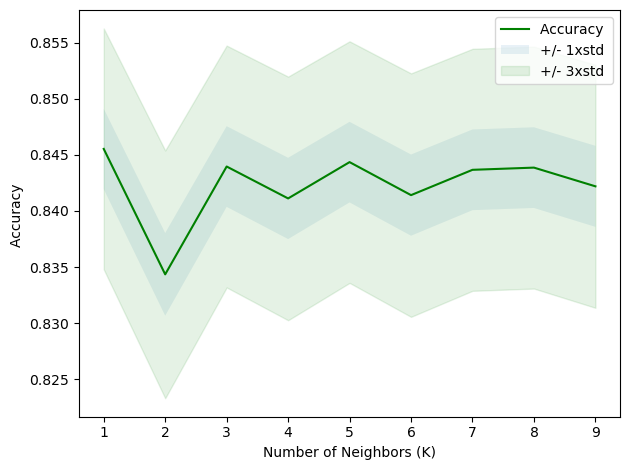

<Figure size 640x480 with 0 Axes>

In [153]:
# K değerine bağlı olarak doğruluk grafiği çizilir (yeşil renk ile)
plt.plot(range(1, Ks), mean_acc, 'g')

# Ortalama doğruluğun etrafındaki +/- 1x standart sapma aralığı görselleştirilir (şeffaf renk ile)
plt.fill_between(range(1, Ks), mean_acc - 1 * std_acc, mean_acc + 1 * std_acc, alpha=0.10)

# Ortalama doğruluğun etrafındaki +/- 3x standart sapma aralığı görselleştirilir (daha belirgin yeşil renk ile)
plt.fill_between(range(1, Ks), mean_acc - 3 * std_acc, mean_acc + 3 * std_acc, alpha=0.10, color="green")

# Grafikte kullanılan çizgiler için bir açıklama eklenir
plt.legend(('Accuracy ', '+/- 1xstd', '+/- 3xstd'))

# Grafik eksenlerine etiket eklenir
plt.ylabel('Accuracy ')
plt.xlabel('Number of Neighbors (K)')

# Grafik düzenini sıkıştırarak optimize edilir
plt.tight_layout()

# Grafiği ekrana basılır
plt.show()

# Grafiği "graph_image.png" adıyla kaydeder, yüksek çözünürlükle
plt.savefig("graph_image.png", dpi=300, bbox_inches='tight')

 # When k=5

In [149]:
# K=5 komşu ile KNN sınıflandırıcısını eğitiyoruz
k = 5
neigh5 = KNeighborsClassifier(n_neighbors=k).fit(X_train_norm, y_train)

# Eğitim seti üzerindeki doğruluk hesaplanır ve yazdırılır
print("Train set Accuracy: ", metrics.accuracy_score(y_train, neigh5.predict(X_train_norm)))

# Test seti üzerindeki doğruluk hesaplanır ve yazdırılır
yhat5 = neigh5.predict(X_test_norm)
print("Test set Accuracy: ", metrics.accuracy_score(y_test, yhat5))

Train set Accuracy:  0.8943713809009717
Test set Accuracy:  0.8443572129538763


#  Cross Validation

In [150]:
# KNN sınıflandırıcısını oluşturuyoruz, k=5 komşu ile
knn_classifier = KNeighborsClassifier(n_neighbors=5)

# 10 katlı çapraz doğrulama için num_folds değişkenini ayarlıyoruz
num_folds = 10

# StratifiedKFold kullanarak her katmanda dengeyi sağlıyoruz (sınıflar dengeli olacak şekilde)
cv_strategy = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=42)

# KNN sınıflandırıcısı ile çapraz doğrulama yapıyoruz ve doğrulukları hesaplıyoruz
cross_val_results = cross_val_score(knn_classifier, X_train_norm, y_train, cv=cv_strategy, scoring='accuracy')

# Çapraz doğrulama sonuçlarını yazdırıyoruz
print("Cross-Validation Results:")
print(cross_val_results)

# Çapraz doğrulamanın ortalama doğruluğunu yazdırıyoruz
print("Mean Accuracy: {:.2f}".format(cross_val_results.mean()))

Cross-Validation Results:
[0.84322866 0.83611384 0.83832188 0.83218842 0.83856722 0.83316977
 0.83779141 0.83779141 0.83828221 0.83141104]
Mean Accuracy: 0.84


In [151]:
print(classification_report(y_test,yhat))

              precision    recall  f1-score   support

           0       0.85      0.84      0.84      5101
           1       0.84      0.85      0.84      5089

    accuracy                           0.84     10190
   macro avg       0.84      0.84      0.84     10190
weighted avg       0.84      0.84      0.84     10190



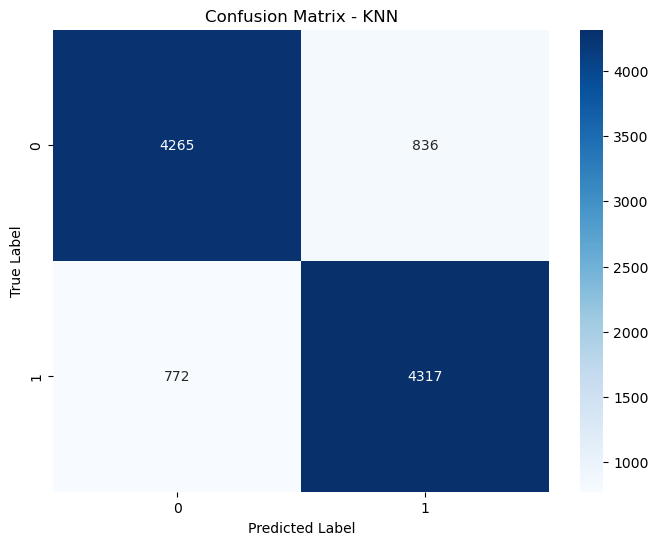

In [155]:
# Confusion matrix (karışıklık matrisi) hesaplanır
conf_matrix_knn = confusion_matrix(y_test, yhat)

# Karışıklık matrisini heatmap olarak görselleştiririz
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_knn, annot=True, fmt='d', cmap='Blues', xticklabels=['0', '1'], yticklabels=['0', '1'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix - KNN')
plt.show()

# Decision Trees

In [156]:
clt = DecisionTreeClassifier(criterion="entropy",max_depth=4)
clt.fit(X_train,y_train)

DecisionTreeClassifier(criterion='entropy', max_depth=4)

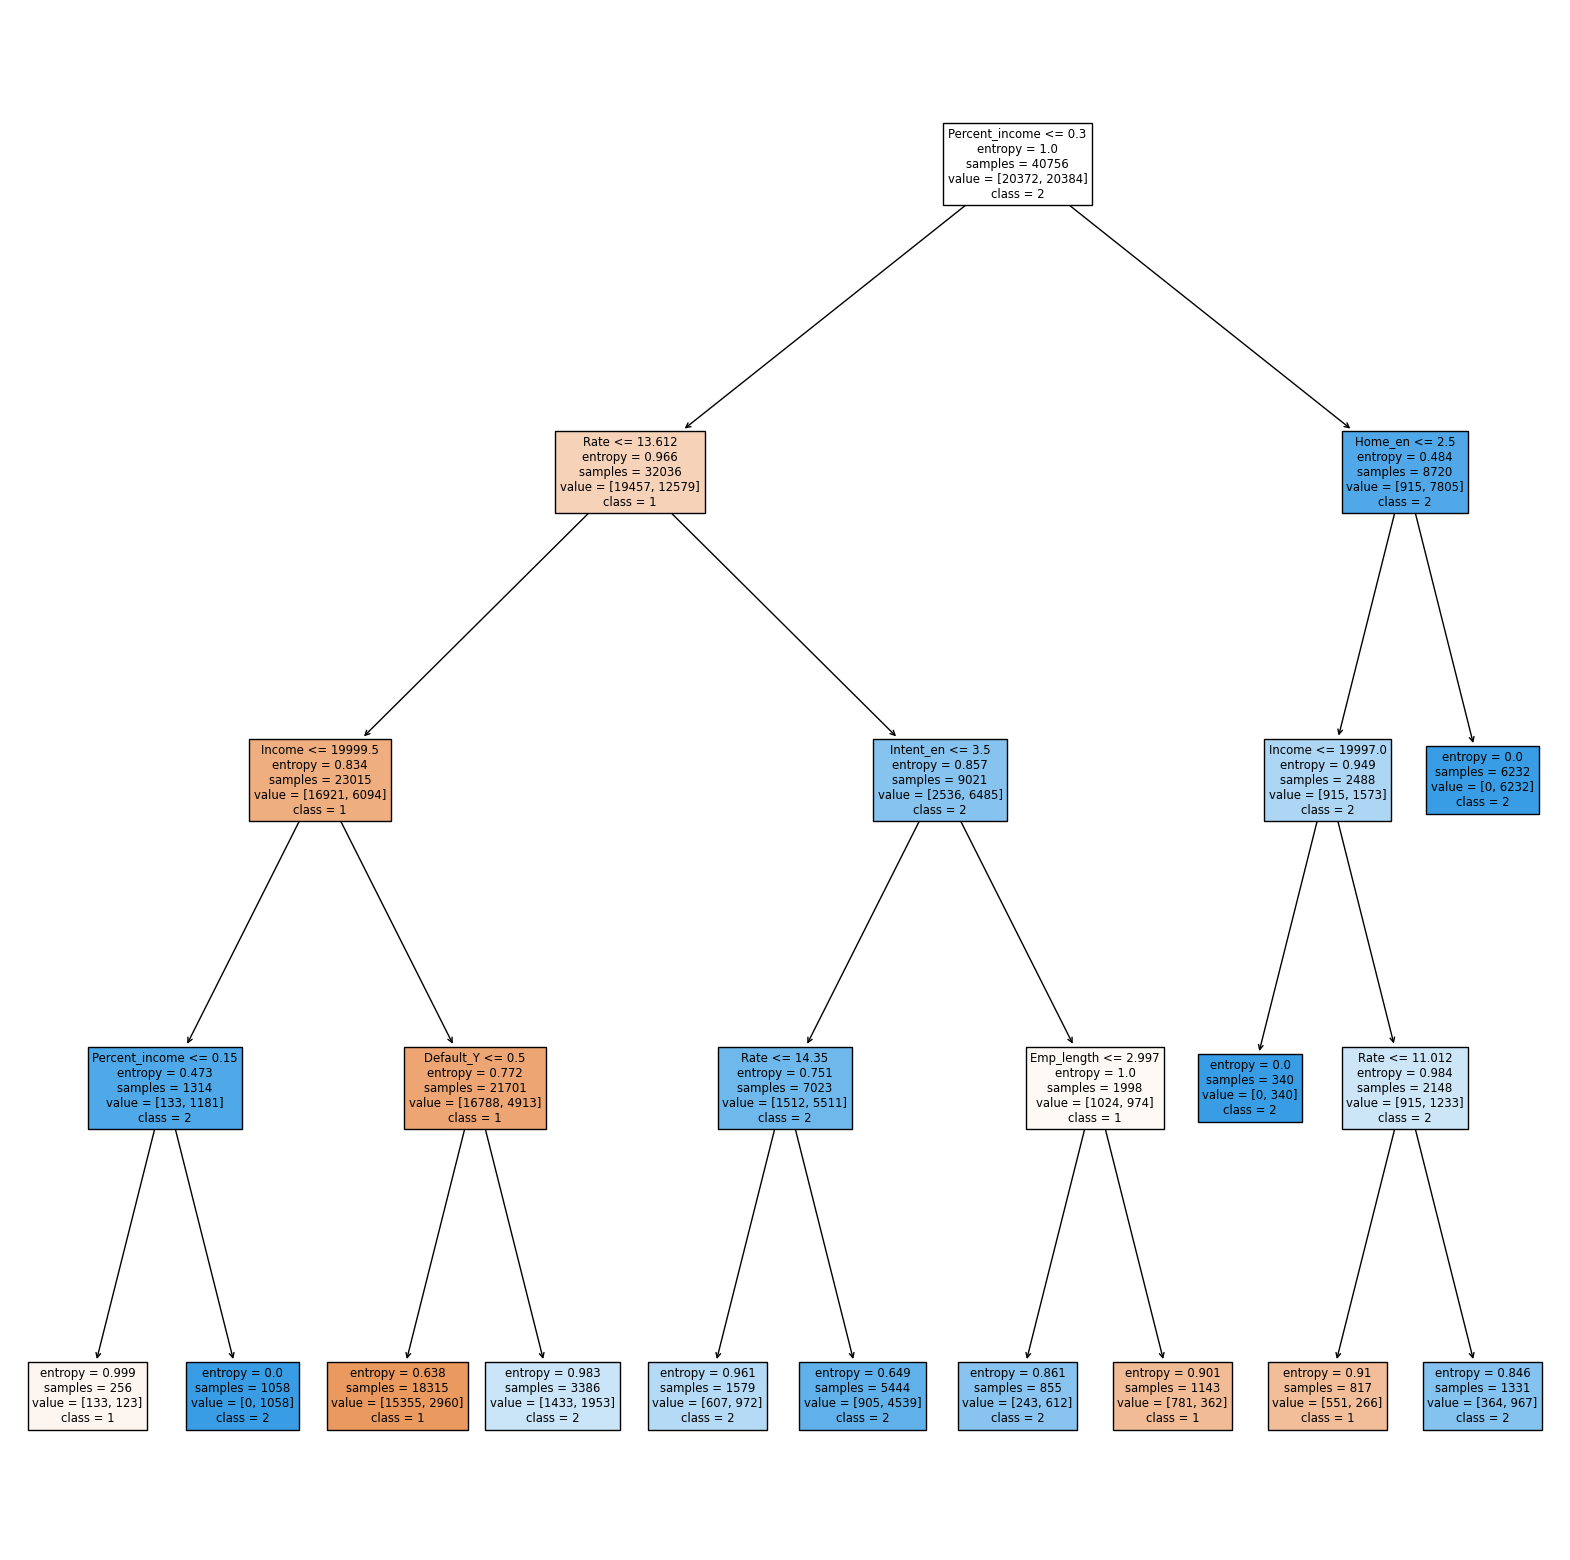

In [177]:
plt.figure(figsize=(20,20))
plot_tree(clt,feature_names=data_12.columns,class_names=["1","2"],filled=True)
plt.show()

# Prediction

In [158]:
y_pred_tree = clt.predict(X_test)

In [178]:
print(y_pred_tree [0:5])
print(y_test [0:5])

[0 1 0 1 0]
[0 1 0 1 1]


In [160]:
confusion_matrix(y_test,y_pred_tree)

array([[4257,  844],
       [ 916, 4173]], dtype=int64)

# Evaluation

In [161]:
print("DecisionTrees's Accuracy: ", metrics.accuracy_score(y_test, y_pred_tree))

DecisionTrees's Accuracy:  0.8272816486751717


In [162]:
print(classification_report(y_test,y_pred_tree))

              precision    recall  f1-score   support

           0       0.82      0.83      0.83      5101
           1       0.83      0.82      0.83      5089

    accuracy                           0.83     10190
   macro avg       0.83      0.83      0.83     10190
weighted avg       0.83      0.83      0.83     10190



# Visualization

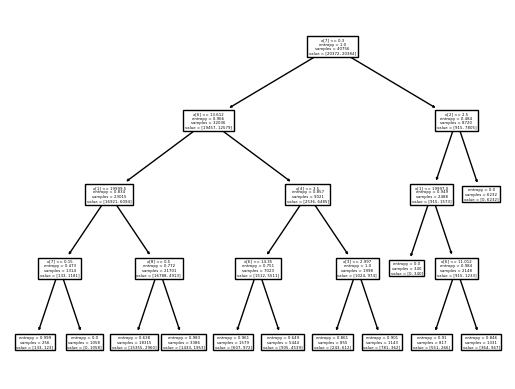

In [163]:
tree.plot_tree(clt)
plt.show()

In [164]:
# num_folds değişkenini 10 olarak belirliyoruz. Bu, çapraz doğrulama için kaç katman kullanılacağını belirtir.
num_folds = 10

# StratifiedKFold, sınıfların dengeli şekilde dağıtılmasını sağlayarak veri kümesini 'n_splits' (katman sayısı) kadar böler.
# 'shuffle=True' ile veriyi karıştırıyoruz ve 'random_state=42' ile rastgelelikin tekrarlanabilir olmasını sağlıyoruz.
cv_strategy = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=42)

# cross_val_score fonksiyonu, verilen model (clt) üzerinde k-katlı çapraz doğrulama yapar.
# 'scoring='accuracy'' ile doğruluk skorunu ölçüyoruz. 'cv=cv_strategy' ile kullanılan çapraz doğrulama stratejisini belirtiyoruz.
cross_val_results = cross_val_score(clt, X_train, y_train, cv=cv_strategy, scoring='accuracy')

# Çapraz doğrulama sonuçlarını yazdırıyoruz.
print("Cross-Validation Results:")
print(cross_val_results)

# Çapraz doğrulama sonuçlarının ortalama doğruluk değerini yazdırıyoruz.
print("Mean Accuracy: {:.2f}".format(cross_val_results.mean()))

Cross-Validation Results:
[0.83366045 0.81624141 0.82433759 0.81844946 0.82016683 0.81476938
 0.81226994 0.81398773 0.83190184 0.82944785]
Mean Accuracy: 0.82


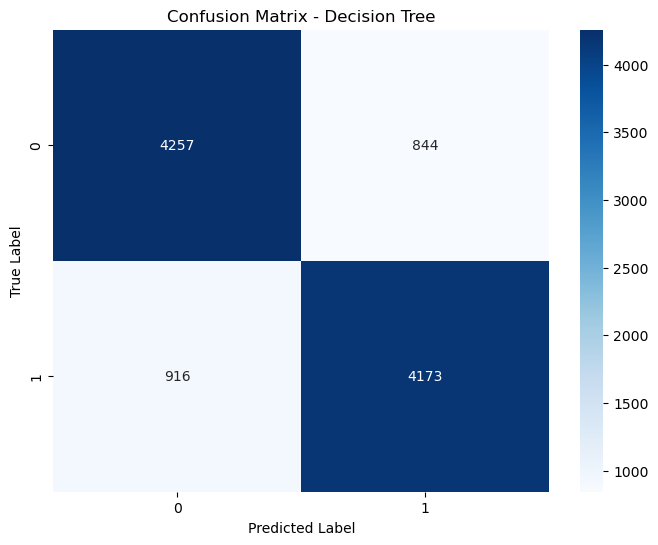

In [165]:
# Compute the confusion matrix
conf_matrix_dt = confusion_matrix(y_test, y_pred_tree)

# Display the confusion matrix using a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_dt, annot=True, fmt='d', cmap='Blues', xticklabels=['0', '1'], yticklabels=['0', '1'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix - Decision Tree')
plt.show()

In [173]:
# Compute and print the accuracy for KNN
accuracy_knn = accuracy_score(y_test, yhat)
print(f"Accuracy (KNN): {accuracy_knn:.2f}")

# Compute and print the accuracy for Decision Tree
accuracy_dt = accuracy_score(y_test, y_pred_tree)
print(f"Accuracy (Decision Tree): {accuracy_dt:.2f}")

Accuracy (KNN): 0.84
Accuracy (Decision Tree): 0.83


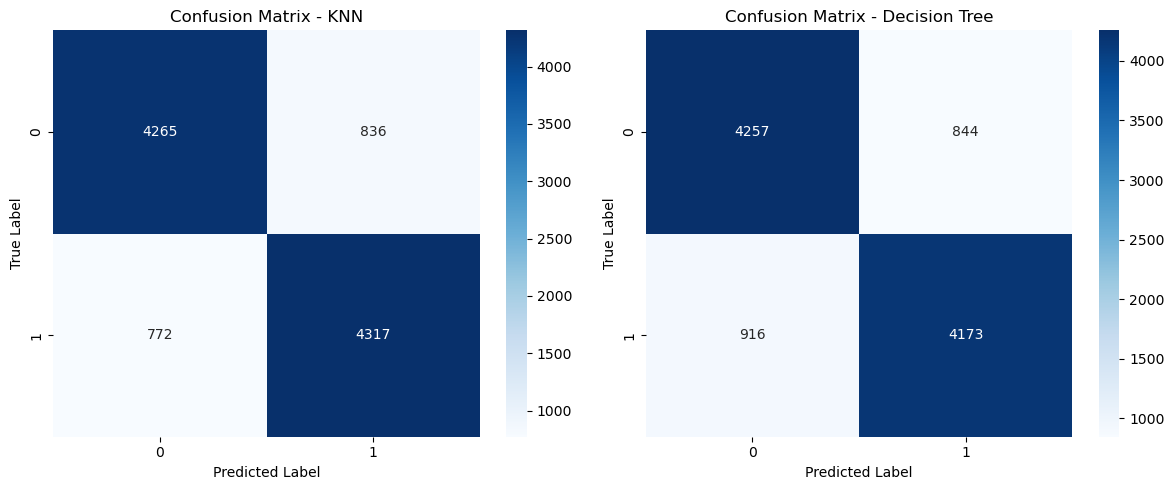

In [174]:
# Plot confusion matrices side by side
conf_matrix_knn = confusion_matrix(y_test, yhat)
conf_matrix_dt = confusion_matrix(y_test, y_pred_tree)

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 5))

# Plot for KNN
sns.heatmap(conf_matrix_knn, annot=True, fmt='d', cmap='Blues', xticklabels=['0', '1'], yticklabels=['0', '1'], ax=axes[0])
axes[0].set_xlabel('Predicted Label')
axes[0].set_ylabel('True Label')
axes[0].set_title('Confusion Matrix - KNN')

# Plot for Decision Tree
sns.heatmap(conf_matrix_dt, annot=True, fmt='d', cmap='Blues', xticklabels=['0', '1'], yticklabels=['0', '1'], ax=axes[1])
axes[1].set_xlabel('Predicted Label')
axes[1].set_ylabel('True Label')
axes[1].set_title('Confusion Matrix - Decision Tree')

plt.tight_layout()
plt.show()

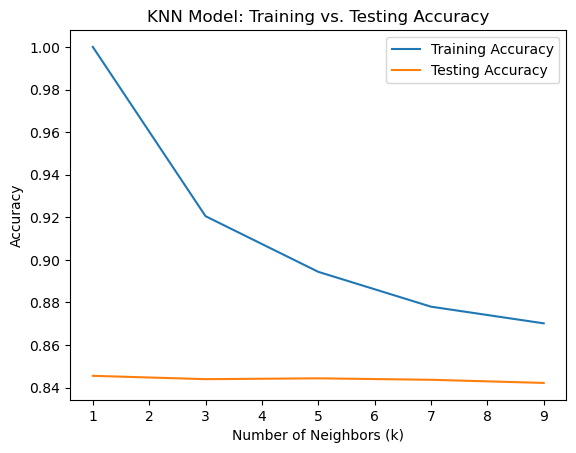

In [179]:
# KNN modeli için k değerleri
k_values = [1, 3, 5, 7, 9]

# Eğitim ve test doğruluklarını hesaplamak için doğrudan bir loop
train_accuracies, test_accuracies = zip(*[
    (KNeighborsClassifier(n_neighbors=k).fit(X_train_norm, y_train).score(X_train_norm, y_train),
     KNeighborsClassifier(n_neighbors=k).fit(X_train_norm, y_train).score(X_test_norm, y_test))
    for k in k_values
])

# Doğrulukları çiz
plt.plot(k_values, train_accuracies, label='Training Accuracy')
plt.plot(k_values, test_accuracies, label='Testing Accuracy')
plt.xlabel('Number of Neighbors (k)')
plt.ylabel('Accuracy')
plt.title('KNN Model: Training vs. Testing Accuracy')
plt.legend()
plt.show()

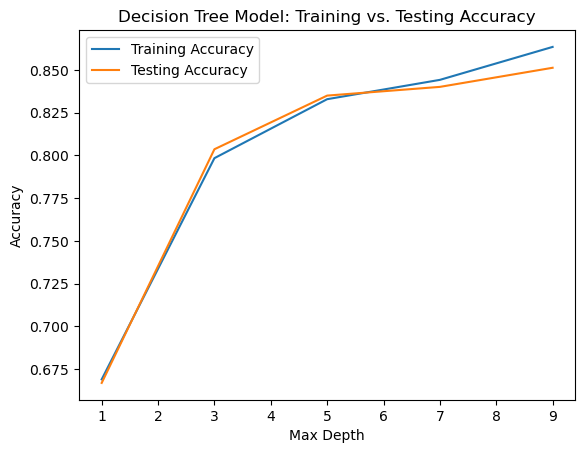

In [180]:
# Decision Tree Model için max_depth değerleri
depth_values = [1, 3, 5, 7, 9]

# Eğitim ve test doğruluklarını hesaplamak için doğrudan bir loop
train_accuracies_dt, test_accuracies_dt = zip(*[
    (DecisionTreeClassifier(max_depth=depth).fit(X_train, y_train).score(X_train, y_train),
     DecisionTreeClassifier(max_depth=depth).fit(X_train, y_train).score(X_test, y_test))
    for depth in depth_values
])

# Doğrulukları çiz
plt.plot(depth_values, train_accuracies_dt, label='Training Accuracy')
plt.plot(depth_values, test_accuracies_dt, label='Testing Accuracy')
plt.xlabel('Max Depth')
plt.ylabel('Accuracy')
plt.title('Decision Tree Model: Training vs. Testing Accuracy')
plt.legend()
plt.show()

In [181]:
# KNN ve Decision Tree modelleri için çapraz doğrulama
knn_scores = cross_val_score(knncl, X_train_norm, y_train, cv=10, scoring='accuracy')
dt_scores = cross_val_score(clt, X, y, cv=10, scoring='accuracy')

# Ortalama doğrulukları yazdır
print(f"KNN Average Accuracy: {knn_scores.mean():.2f}")
print(f"Decision Tree Average Accuracy: {dt_scores.mean():.2f}")

KNN Average Accuracy: 0.84
Decision Tree Average Accuracy: 0.82
